In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import joblib

# optional, for progress bars
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import wilcoxon


def get_bootstrap_aucs(y_true, y_pred, bootstrap_iters=100):
    rng = np.random.RandomState(seed=42)
    idxs = list(range(y_pred.shape[0]))

    bootstrap_aucs = []
    for _ in range(bootstrap_iters):
        curr_idxs = rng.choice(idxs, size=len(idxs), replace=True)
        bootstrap_aucs.append(roc_auc_score(y_true[curr_idxs], y_pred[curr_idxs],
                                            multi_class='ovr', average='macro'))

    return np.median(bootstrap_aucs), bootstrap_aucs


def get_p_values(all_aucs):
    all_aucs = np.vstack(all_aucs)
    median_aucs = np.median(all_aucs, -1)
    second_best_idx, best_idx = median_aucs.argsort()[-2:]
    p_val = wilcoxon(all_aucs[best_idx], all_aucs[second_best_idx])[1]
    return p_val, (best_idx, second_best_idx)


def pval_to_str(p_val):
    if p_val < 0.0001:
        p_val = 'p<0.0001'
        p_val = '***'
    else:
        p_val = f'p={p_val:.4f}'
    return p_val


def darken_hex(hex_color, factor=0.5):
    # Ensure the factor is between 0 and 1
    factor = max(0, min(factor, 1))

    # Remove the hash symbol if present
    hex_color = hex_color.lstrip('#')

    # Convert hex to RGB
    rgb = tuple(int(hex_color[i:i + 2], 16) for i in (0, 2, 4))

    # Darken the RGB values by multiplying by the factor
    darkened_rgb = tuple(int(c * factor) for c in rgb)

    # Convert the RGB values back to hex
    darkened_hex = '#{:02x}{:02x}{:02x}'.format(*darkened_rgb)

    return darkened_hex


dftrain = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv')
dftest = pd.read_csv('/mnt/e/IDRiD_B_DiseaseGrading/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv')
name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/IRID_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/IRID_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green', 
     'IRID_Train_X_ours.npy',
     'IRID_Test_X_ours.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green']
colors = ['#ff595e', '#ffca3a', '#8ac926']


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8622	Mac. Edema:0.5361	No/Mild vs rest:0.7631	AnyDR:0.7982	AnyDME:0.8313
Total time: 0.6323s / mean time: 0.1265s


  0%|          | 0/5 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8661	Mac. Edema:0.5709	No/Mild vs rest:0.6566	AnyDR:0.8168	AnyDME:0.9047
Total time: 0.4808s / mean time: 0.0962s


  0%|          | 0/5 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.8900	Mac. Edema:0.5609	No/Mild vs rest:0.7671	AnyDR:0.8197	AnyDME:0.8833
Total time: 0.1521s / mean time: 0.0304s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,Mac. Edema Grade 0,Mac. Edema Grade 1,Mac. Edema Grade 2,No/Mild vs rest,AnyDR,AnyDME
RETFound-MEH,RETFound-MEH,0.8622,0.5361,0.7631,0.7982,0.8313,0.8834,0.7117,0.8888,0.9240,0.8687,0.8922
DERETFound,DERETFound,0.8661,0.5709,0.6566,0.8168,0.9047,0.8781,0.7583,0.8706,0.9046,0.8721,0.8737
RETFound-Green,RETFound-Green,0.8900,0.5609,0.7671,0.8197,0.8833,0.9131,0.7278,0.8772,0.9160,0.9017,0.9168


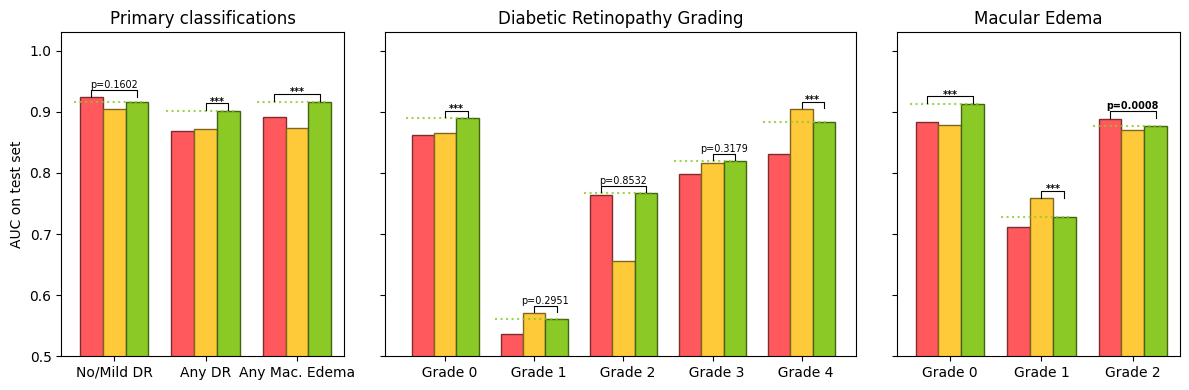

Statistically significant wins:  {'RETFound-MEH': 1, 'DERETFound': 2, 'RETFound-Green': 4}
Ties for first place:  {'RETFound-MEH': 2, 'DERETFound': 2, 'RETFound-Green': 4}


In [2]:
def run_idrid_exp(name_X_list, models, colors,
                  figsize=(12, 4), dashed_line_offsets=(-2.75, 0.25), xtick_loc_scaling=1, title_size='large'):
    targets = ['DR Grade', 'Mac. Edema', 'No/Mild vs rest', 'AnyDR', 'AnyDME']

    results_df = pd.DataFrame(
        columns=['Name'] + [f'DR Grade {_}' for _ in range(5)] 
                + [f'Mac. Edema Grade {_}' for _ in range(3)] 
                + ['No/Mild vs rest', 'AnyDR', 'AnyDME'])
    name_bootstrap_aucs_dict = {}
    name_times_dict = {}
    for name, X_train_fname, X_test_fname in tqdm(name_X_list):
        np.random.seed(42)

        name_times_dict[name] = []
        median_aucs = []

        X_train = np.load(X_train_fname)
        X_test = np.load(X_test_fname)

        perf_str = f'{name:>20}:'
        for target_col in tqdm(targets, leave=True):

            if target_col.startswith('DR Grade'):
                y_train = dftrain['Retinopathy grade']
                y_test = dftest['Retinopathy grade']

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                for grade in range(5):
                    curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test == grade, preds[:, grade])
                    name_bootstrap_aucs_dict[f'{name}-DR Grade {grade}'] = curr_bootstrap_aucs
                    median_aucs.append(curr_median_auc)


            elif target_col.startswith('Mac. Edema'):
                y_train = dftrain['Risk of macular edema ']
                y_test = dftest['Risk of macular edema ']

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                for grade in range(3):
                    curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test == grade, preds[:, grade])
                    name_bootstrap_aucs_dict[f'{name}-Mac. Edema Grade {grade}'] = curr_bootstrap_aucs
                    median_aucs.append(curr_median_auc)

            elif target_col.startswith('No/Mild vs rest'):
                y_train = dftrain['Retinopathy grade'].apply(lambda x: x > 1).values
                y_test = dftest['Retinopathy grade'].apply(lambda x: x > 1).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:, 1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)
                
            elif target_col.startswith('AnyDR'):
                y_train = dftrain['Retinopathy grade'].apply(lambda x: x > 0).values
                y_test = dftest['Retinopathy grade'].apply(lambda x: x > 0).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:, 1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)

            elif target_col.startswith('AnyDME'):
                y_train = dftrain['Risk of macular edema '].apply(lambda x: x > 0).values
                y_test = dftest['Risk of macular edema '].apply(lambda x: x > 0).values

                start = time.time()
                clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=20_000, random_state=42))
                clf.fit(X_train, y_train)
                preds = clf.predict_proba(X_test)[:, 1]
                stop = time.time()
                delta = stop - start
                name_times_dict[name].append(delta)

                curr_median_auc, curr_bootstrap_aucs = get_bootstrap_aucs(y_test, preds)
                name_bootstrap_aucs_dict[f'{name}-{target_col}'] = curr_bootstrap_aucs
                median_aucs.append(curr_median_auc)

            else:
                raise ValueError

        perf_str += '\t'.join([f'{c}:{v:.4f}' for c, v in zip(targets, median_aucs)])
        print(perf_str)
        print(f'Total time: {sum(name_times_dict[name]):.4f}s / mean time: {np.mean(name_times_dict[name]):.4f}s')

        results_df.loc[name] = [name] + median_aucs

    display(results_df.round(4))

    fig, axes = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [3, 5, 3]})
    axes = axes.flat

    width = 0.25

    target_groups = {
        'Primary classifications': ['No/Mild vs rest', 'AnyDR', 'AnyDME'],
        'Diabetic Retinopathy Grading': [f'DR Grade {_}' for _ in range(5)],
        'Macular Edema': [f'Mac. Edema Grade {_}' for _ in range(3)]
    }

    wins = {_: 0 for _ in models}
    ties = {_: 0 for _ in models}

    for target_group, ax in zip(target_groups, axes):
        targets = target_groups[target_group]
        x = np.arange(len(targets))

        for i, model in enumerate(models):
            values = [results_df.loc[model, target] for target in targets]
            locs = x + i * width
            ax.bar(locs, values, width, label=model, color=colors[i], edgecolor=darken_hex(colors[i]))
            if model == 'RETFound-Green':
                for _idx in range(len(values)):
                    _left = locs[_idx] + dashed_line_offsets[0] * width
                    _right = locs[_idx] + dashed_line_offsets[1] * width
                    _val = values[_idx]
                    ax.plot([_left, _right], [_val, _val], c=colors[i], linewidth=1.5, alpha=0.8, linestyle=':')

        # plot stat significance
        for t_idx, target in enumerate(targets):
            target_str = target.replace(" vs Rest", "")
            aucs = [name_bootstrap_aucs_dict[f'{name}-{target}'] for name in models]
            p_val, (best_idx, second_best_idx) = get_p_values(aucs)
            best_val = np.median(np.vstack(aucs), axis=-1).max()

            if p_val < 0.05:
                wins[models[best_idx]] += 1
            else:
                ties[models[best_idx]] += 1
                ties[models[second_best_idx]] += 1

            start_loc = t_idx + best_idx * width
            end_loc = t_idx + second_best_idx * width

            ax.plot([start_loc, start_loc, end_loc, end_loc],
                    [best_val + 0.001, best_val + 0.012, best_val + 0.012, best_val + 0.001],
                    c='black', lw=0.8)
            text_loc_height_offset = 0.015 if not p_val < 0.0001 else 0.01
            ax.text((start_loc + end_loc) / 2, best_val + text_loc_height_offset, pval_to_str(p_val), ha='center',
                    fontsize='x-small',
                    weight=None if not p_val < 0.05 else 'bold')

            ax.set_xticks(x + width * xtick_loc_scaling)
            targets_display = [_.replace('_', ' ').title() for _ in targets]
            targets_display = [_.replace('Dr', " ").replace('Mac. Edema ', '')
                               for _ in targets_display]
            targets_display = [_.replace('Anydr', "Any DR").replace('Anydme', "Any Mac. Edema").replace('Vs Rest', 'DR')
                               for _ in targets_display]
            if title_size=='medium':
                targets_display = [_.replace('Mac. Edema', "ME")
                                   for _ in targets_display]
            ax.set_xticklabels(targets_display, rotation=0, ha='center', fontsize='medium' if title_size=='large' else 10)
            ax.set_ylim(0.5, 1.03)
            ax.set_title(target_group, fontsize=title_size)

    axes[0].set_ylabel('AUC on test set')
    axes[1].set_yticklabels([])
    axes[2].set_yticklabels([])
    plt.tight_layout()
    plt.show()

    print('Statistically significant wins: ', wins)
    print('Ties for first place: ', ties)


run_idrid_exp(name_X_list, models, colors)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

      RETFound-Green:DR Grade:0.8900	Mac. Edema:0.5609	No/Mild vs rest:0.7671	AnyDR:0.8197	AnyDME:0.8833
Total time: 0.1387s / mean time: 0.0277s


  0%|          | 0/5 [00:00<?, ?it/s]

              DinoV2:DR Grade:0.8687	Mac. Edema:0.6274	No/Mild vs rest:0.7404	AnyDR:0.8132	AnyDME:0.8396
Total time: 0.1970s / mean time: 0.0394s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,Mac. Edema Grade 0,Mac. Edema Grade 1,Mac. Edema Grade 2,No/Mild vs rest,AnyDR,AnyDME
RETFound-Green,RETFound-Green,0.8900,0.5609,0.7671,0.8197,0.8833,0.9131,0.7278,0.8772,0.9160,0.9017,0.9168
DinoV2,DinoV2,0.8687,0.6274,0.7404,0.8132,0.8396,0.9150,0.7128,0.9022,0.9101,0.8721,0.9209


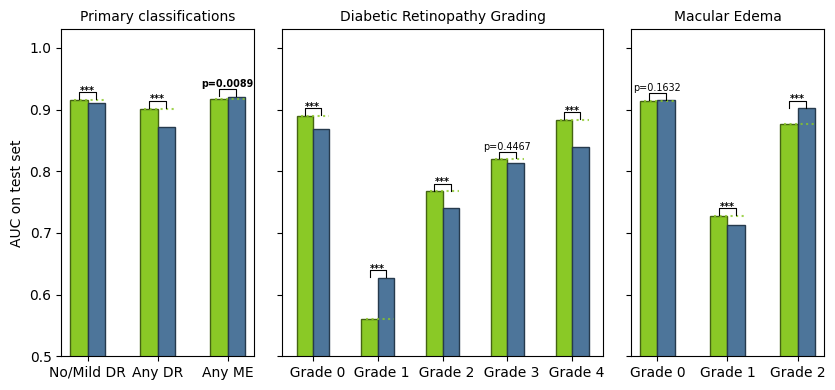

Statistically significant wins:  {'RETFound-Green': 6, 'DinoV2': 3}
Ties for first place:  {'RETFound-Green': 2, 'DinoV2': 2}


In [3]:
name_X_list = [
    ('RETFound-Green', 
     'IRID_Train_X_ours.npy',
     'IRID_Test_X_ours.npy'),
    ('DinoV2', 
     'IRID_Train_X_dino392.npy',
     'IRID_Test_X_dino392.npy'),
]

models = ['RETFound-Green', 'DinoV2']
colors = ['#8ac926', '#4d759a']

run_idrid_exp(name_X_list, models, colors,
              figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

        RETFound-MEH:DR Grade:0.8622	Mac. Edema:0.5361	No/Mild vs rest:0.7631	AnyDR:0.7982	AnyDME:0.8313
Total time: 0.3792s / mean time: 0.0758s


  0%|          | 0/5 [00:00<?, ?it/s]

          DERETFound:DR Grade:0.8661	Mac. Edema:0.5709	No/Mild vs rest:0.6566	AnyDR:0.8168	AnyDME:0.9047
Total time: 0.3810s / mean time: 0.0762s


  0%|          | 0/5 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.8696	Mac. Edema:0.7500	No/Mild vs rest:0.6392	AnyDR:0.7770	AnyDME:0.7857
Total time: 0.4451s / mean time: 0.0890s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,Mac. Edema Grade 0,Mac. Edema Grade 1,Mac. Edema Grade 2,No/Mild vs rest,AnyDR,AnyDME
RETFound-MEH,RETFound-MEH,0.8622,0.5361,0.7631,0.7982,0.8313,0.8834,0.7117,0.8888,0.9240,0.8687,0.8922
DERETFound,DERETFound,0.8661,0.5709,0.6566,0.8168,0.9047,0.8781,0.7583,0.8706,0.9046,0.8721,0.8737
RETFound-Green@224,RETFound-Green@224,0.8696,0.7500,0.6392,0.7770,0.7857,0.9044,0.7032,0.8687,0.9245,0.8708,0.8879


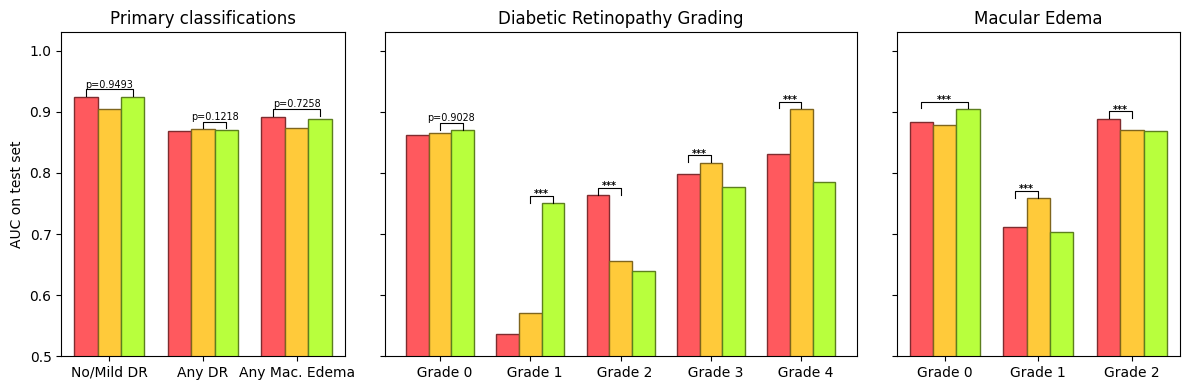

Statistically significant wins:  {'RETFound-MEH': 2, 'DERETFound': 3, 'RETFound-Green@224': 2}
Ties for first place:  {'RETFound-MEH': 2, 'DERETFound': 2, 'RETFound-Green@224': 4}


In [4]:
name_X_list = [
    ('RETFound-MEH', 
     '/home/justin/RETFound_MAE/IRID_Train_RETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_RETFound_Feature_latent.npy'),
    ('DERETFound', 
     '/home/justin/RETFound_MAE/IRID_Train_DERETFound_Feature_latent.npy',
     '/home/justin/RETFound_MAE/IRID_Test_DERETFound_Feature_latent.npy'),
    ('RETFound-Green@224', 
     'IRID_Train_X_ours224.npy',
     'IRID_Test_X_ours224.npy'),
]
models = ['RETFound-MEH', 'DERETFound', 'RETFound-Green@224']
colors = ['#ff595e', '#ffca3a', '#B8FF3D']

run_idrid_exp(name_X_list, models, colors)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  RETFound-Green@224:DR Grade:0.8696	Mac. Edema:0.7500	No/Mild vs rest:0.6392	AnyDR:0.7770	AnyDME:0.7857
Total time: 0.2110s / mean time: 0.0422s


  0%|          | 0/5 [00:00<?, ?it/s]

          DinoV2@224:DR Grade:0.8277	Mac. Edema:0.7104	No/Mild vs rest:0.5799	AnyDR:0.7663	AnyDME:0.8907
Total time: 0.1920s / mean time: 0.0384s


,Name,DR Grade 0,DR Grade 1,DR Grade 2,DR Grade 3,DR Grade 4,Mac. Edema Grade 0,Mac. Edema Grade 1,Mac. Edema Grade 2,No/Mild vs rest,AnyDR,AnyDME
RETFound-Green@224,RETFound-Green@224,0.8696,0.7500,0.6392,0.7770,0.7857,0.9044,0.7032,0.8687,0.9245,0.8708,0.8879
DinoV2@224,DinoV2@224,0.8277,0.7104,0.5799,0.7663,0.8907,0.8755,0.6361,0.8737,0.8911,0.8058,0.8791


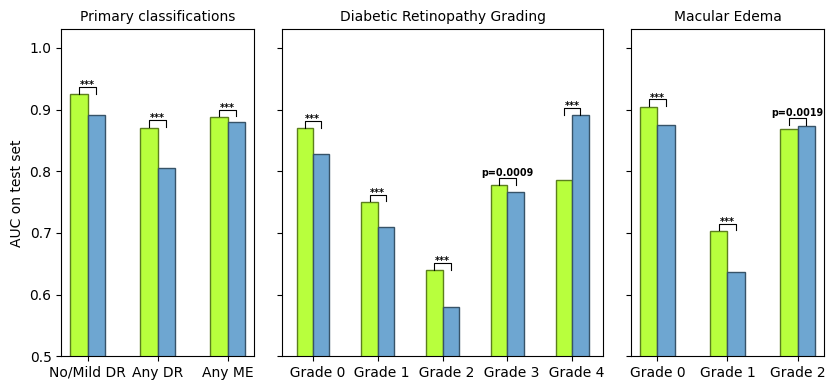

Statistically significant wins:  {'RETFound-Green@224': 9, 'DinoV2@224': 2}
Ties for first place:  {'RETFound-Green@224': 0, 'DinoV2@224': 0}


In [5]:
name_X_list = [
    ('RETFound-Green@224', 
     'IRID_Train_X_ours224.npy',
     'IRID_Test_X_ours224.npy'),
    ('DinoV2@224', 
     'IRID_Train_X_dino224.npy',
     'IRID_Test_X_dino224.npy'),
]

models = ['RETFound-Green@224', 'DinoV2@224']
colors = ['#B8FF3D', '#6EA6D1']

run_idrid_exp(name_X_list, models, colors,
              figsize=(8.5, 4), dashed_line_offsets=(-0.25, 1.5), xtick_loc_scaling=0.5, title_size='medium')